In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from synthlearners import Synth
from synthlearners.utils import prepare_panel
from synthlearners.crossvalidation import PanelCrossValidator

In [2]:
config = SimulationConfig(
    N=100,
    T=50,
    T_pre=40,
    n_treated=10,
    selection_mean=1.0,
    treatment_effect=0.5,
    dgp=FactorDGP(K=2, sigma=1, time_fac_lb=-0.1, time_fac_ub=0.1, trend_sigma=0.0001),
)
simulator = PanelSimulator(config)
Y, Y_0, L, treated_units = simulator.simulate()

In [3]:
treated_units

array([89, 32, 13, 80, 85, 28, 82, 45,  9, 64])

In [4]:
from synthlearners.mcnnm import MatrixCompletionEstimator

In [5]:
# Create a mask indicating which entries are observed.
mask = np.ones_like(Y)
missing_periods = config.T-config.T_pre

# For treated units, suppose the outcomes in the last N periods are missing.
mask[treated_units, -missing_periods:] = 0

In [6]:
print(mask.size)
print(np.sum(mask))
print(np.sum(mask)/mask.size)

5000
4900.0
0.98


In [7]:
mask[treated_units[0]]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
estimator = MatrixCompletionEstimator(
    max_iter=500,
    tol=1e-6,
    verbose=True
)
estimator.fit(Y, mask)
Y_completed = estimator.completed_matrix_

Max lambda: 0.007533186137141103
CV ratio in observation: 0.98
Trying lambda: 0.0


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 1e-05


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 2.087681774518581e-05


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 4.35841519165706e-05


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 9.098983961407352e-05


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 0.00018995782982867028


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 0.0003965714992604174


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 0.0008279150912994823


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 0.0017284232469548181


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 0.003608397711321806


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 0.007533186137141101


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda list: [0.00000000e+00 1.00000000e-05 2.08768177e-05 4.35841519e-05
 9.09898396e-05 1.89957830e-04 3.96571499e-04 8.27915091e-04
 1.72842325e-03 3.60839771e-03 7.53318614e-03]
Best lambda: 0.0, Best score: 0.02068779760792152
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 5.3018520855687284e-30


In [9]:
# Counterfactual Values for imputed periods for single treated example
Y_0[treated_units[0], -missing_periods:]

array([-0.76488391, -0.15174888, -0.13119737,  0.30966483,  0.12721515,
        0.81209996,  0.97510635, -1.01615275,  0.85462799, -1.3490142 ])

In [10]:
# Observed Value for imputed periods from single treated example
Y[treated_units[0], -missing_periods:]

array([-0.26488391,  0.34825112,  0.36880263,  0.80966483,  0.62721515,
        1.31209996,  1.47510635, -0.51615275,  1.35462799, -0.8490142 ])

In [11]:
# MC Values for imputed periods for single treated example
Y_completed[treated_units[0], -missing_periods:]

array([-4.51578755e-16,  2.38766534e-15,  4.23043154e-15, -5.54618021e-16,
       -9.36502403e-16,  1.17470282e-15,  5.01450957e-16,  2.02685455e-16,
        6.23706141e-16,  4.35097663e-17])

In [12]:
baseline_bias = (
    Y_completed[treated_units[0], -missing_periods:]
    - Y_0[treated_units[0], -missing_periods:]
)
print(
    "Baseline Bias of MC value relative to actual counterfactual",
    np.mean(baseline_bias),
)

Baseline Bias of MC value relative to actual counterfactual 0.03342828412030825


In [13]:
te = (
    Y[treated_units[0], -missing_periods:]
    - Y_completed[treated_units[0], -missing_periods:]
)
print("Estimated Treatment Effect of Observed relative to MC Value", np.mean(te))

Estimated Treatment Effect of Observed relative to MC Value 0.46657171587969176


In [14]:
print("Treatment Effect Bias", np.abs(np.mean(te) - config.treatment_effect))

Treatment Effect Bias 0.03342828412030824


In [15]:
estimator2 = MatrixCompletionEstimator(max_iter=500, tol=1e-10, verbose=True)
# Try approach with fixed effects
estimator2.fit(Y, mask, unit_intercept=True, time_intercept=True)
Y_completed2 = estimator2.completed_matrix_

Max lambda: 0.007299648031903805
CV ratio in observation: 0.98
Trying lambda: 0.0


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 1e-05


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 2.080389522189182e-05


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 4.328020564034532e-05


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 9.003968633236754e-05


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 0.00018731762002705788


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 0.00038969361402570564


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 0.0008107145114831124


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 0.001686601975176188


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 0.00350878907726012


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Trying lambda: 0.007299648031903801


Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda list: [0.00000000e+00 1.00000000e-05 2.08038952e-05 4.32802056e-05
 9.00396863e-05 1.87317620e-04 3.89693614e-04 8.10714511e-04
 1.68660198e-03 3.50878908e-03 7.29964803e-03]
Best lambda: 0.007299648031903801, Best score: 0.021071916204335107
shrink_treshhold: 17.884137678164315
Terminated at iteration: 0, for lambda_L: 0.007299648031903801, with obj_val: 1.0032664410550731


In [16]:
# MC Values for imputed periods for single treated example
Y_completed2[treated_units[0], -missing_periods:]

array([-0.52611637, -0.1970256 , -0.18395093, -0.46182075, -0.49687602,
       -0.07055847, -0.20792772, -0.23242434, -0.16218514, -0.2237233 ])

In [17]:
baseline_bias2 = (
    Y_completed2[treated_units[0], -missing_periods:]
    - Y_0[treated_units[0], -missing_periods:]
)
print(
    "Baseline Bias of MC value relative to actual counterfactual",
    np.mean(baseline_bias2),
)

Baseline Bias of MC value relative to actual counterfactual -0.24283257929370175


In [18]:
te2 = (
    Y[treated_units[0], -missing_periods:]
    - Y_completed2[treated_units[0], -missing_periods:]
)
print("Estimated Treatment Effect of Observed relative to MC Value", np.mean(te2))

Estimated Treatment Effect of Observed relative to MC Value 0.7428325792937016


In [19]:
print("Treatment Effect Bias", np.abs(np.mean(te2) - config.treatment_effect))

Treatment Effect Bias 0.2428325792937016


In [2]:
adh_data = pd.read_csv("ADH2015.csv", index_col=0)
adh_data = adh_data[['country', 'year', 'gdp']]
# manually create treatment indicator
adh_data['treat'] = np.where((adh_data.country == "West Germany") & (adh_data.year > 1990), 1, 0)
adh_data.head()

,country,year,gdp,treat
index,,,,
1.0,USA,1960.0,2879,0
1.0,USA,1961.0,2929,0
1.0,USA,1962.0,3103,0
1.0,USA,1963.0,3227,0
1.0,USA,1964.0,3420,0


In [3]:
data = prepare_panel(
    adh_data,
    unit_col="country",
    time_col="year",
    outcome_col="gdp",
    treatment_col="treat",
)

Text(0.5, 1.0, 'Treatment matrix')

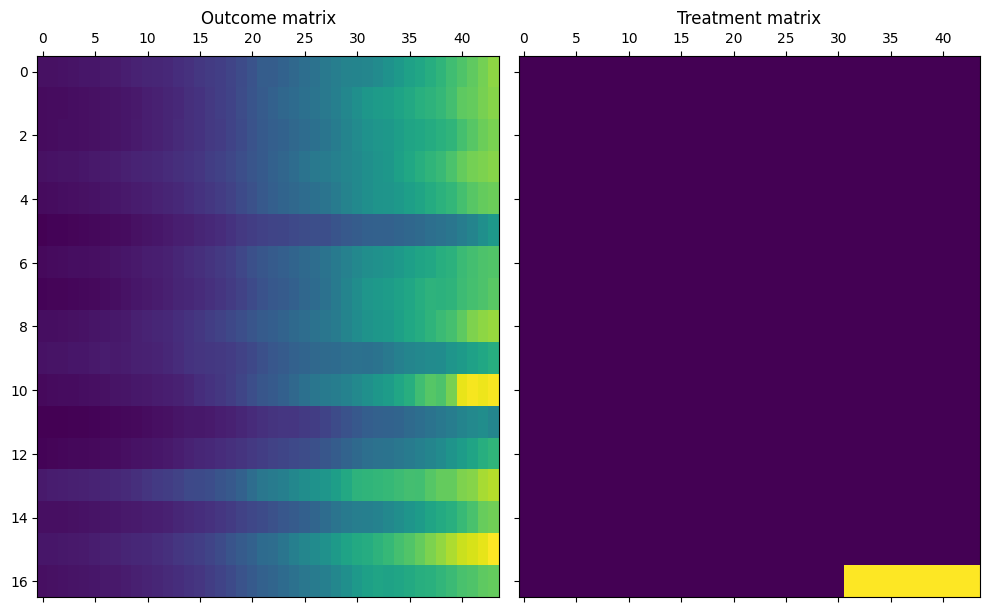

In [4]:
f, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
ax[0].matshow(data["Y"], aspect="auto", cmap="viridis")
ax[1].matshow(data["W"], aspect="auto", cmap="viridis")
f.tight_layout()
ax[0].set_title("Outcome matrix")
ax[1].set_title("Treatment matrix")

In [30]:
n_split_cnt = 4
cv = PanelCrossValidator(n_splits=n_split_cnt)

In [31]:
def plot_masks(m):
    f, ax = plt.subplots(len(m), 2, figsize=(10, 10), sharey=True)

    for n in range(len(m)):
        ax[n,0].matshow(m[n][0], aspect="auto", cmap="viridis")
        ax[n,1].matshow(m[n][1], aspect="auto", cmap="viridis")

    f.tight_layout()
    ax[0,0].set_title("Train matrix")
    ax[0,1].set_title("Test matrix")

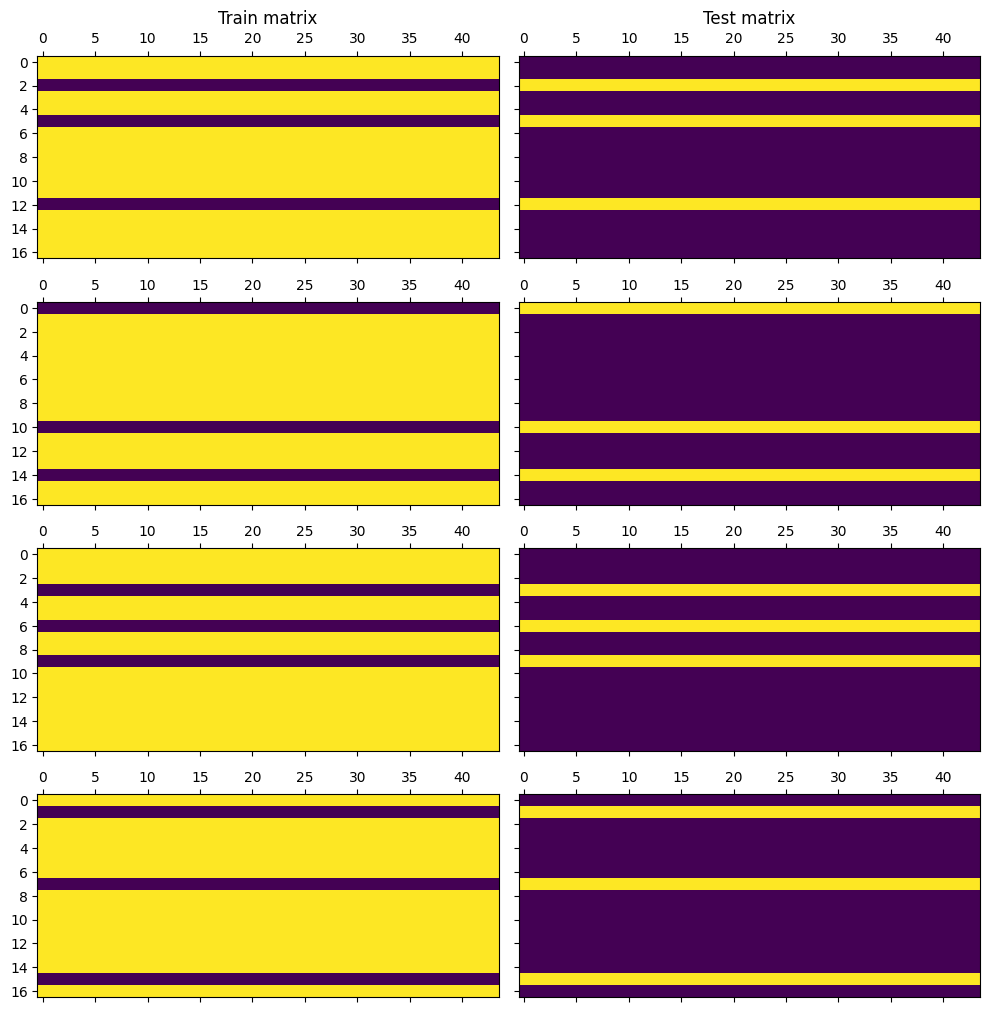

In [32]:
horizontal_masks = cv.horizontal_split(data["Y"])
plot_masks(horizontal_masks)

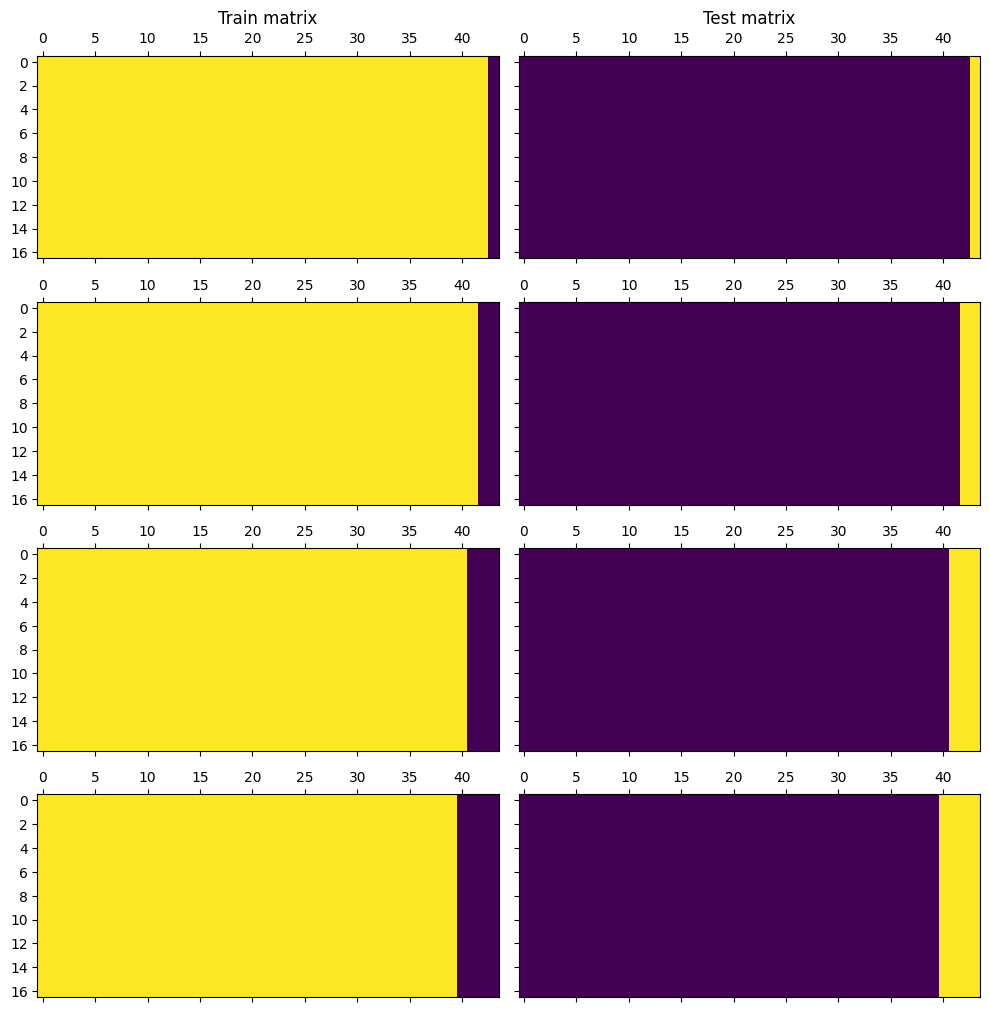

In [33]:
vertical_masks = cv.vertical_split(data["Y"])
plot_masks(vertical_masks)

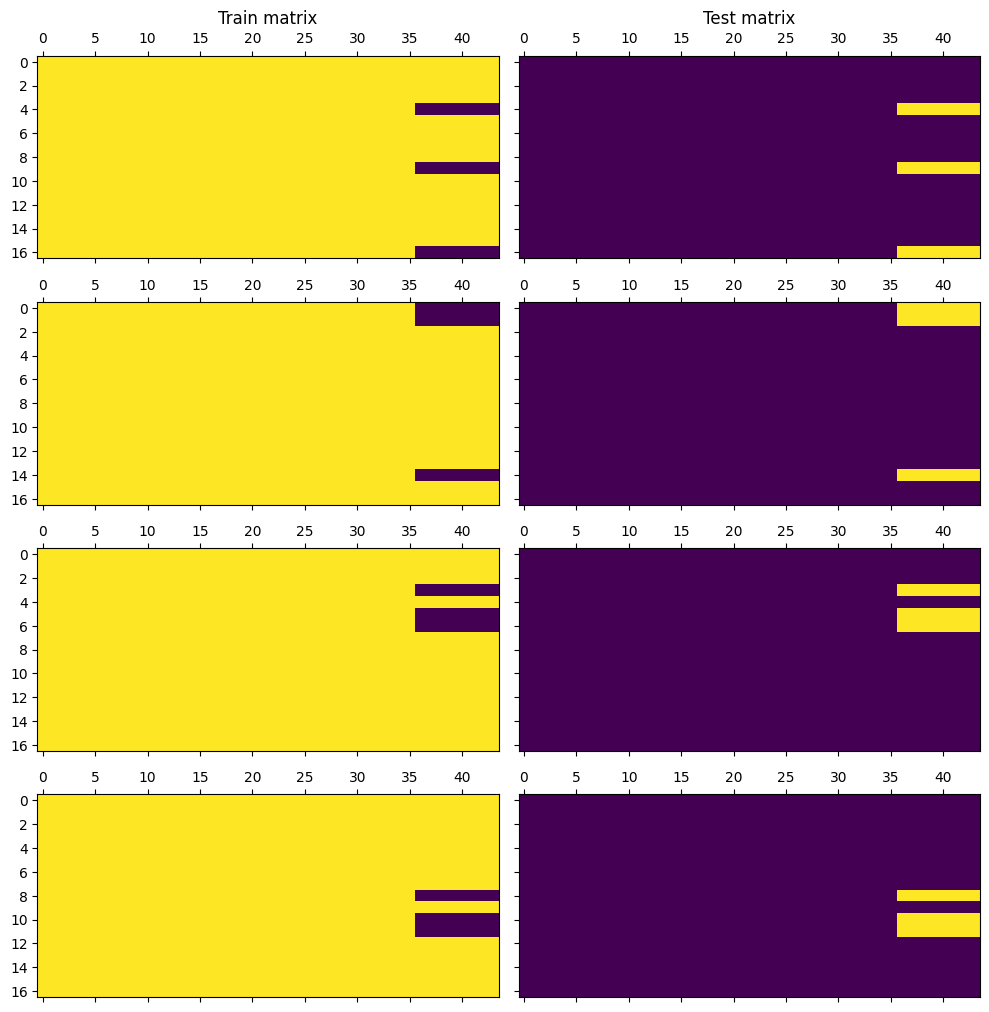

In [34]:
box_masks = cv.box_split(data["Y"])
plot_masks(box_masks)

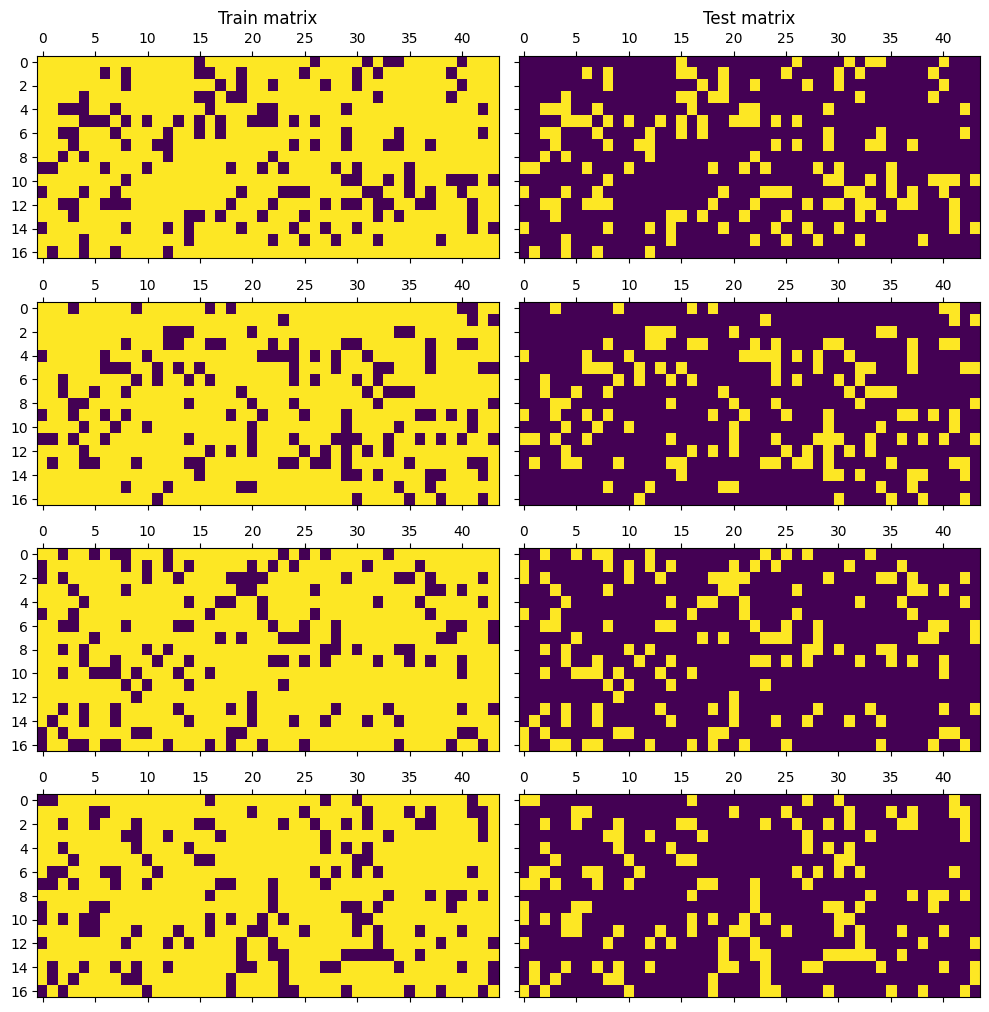

In [35]:
random_masks = cv.random_split(data["Y"])
plot_masks(random_masks)